In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split

from utils import *

plt.style.use('ggplot')

## Data loading

,Kilopris (kr),Vekt (tonn)
uke,,
2000-01-03,30.98,3728
2000-01-10,31.12,4054
2000-01-17,31.03,4043
2000-01-24,30.95,3730
2000-01-31,31.30,3831
...,...,...
2023-07-17,92.67,17898
2023-07-24,86.14,19604
2023-07-31,83.28,20469


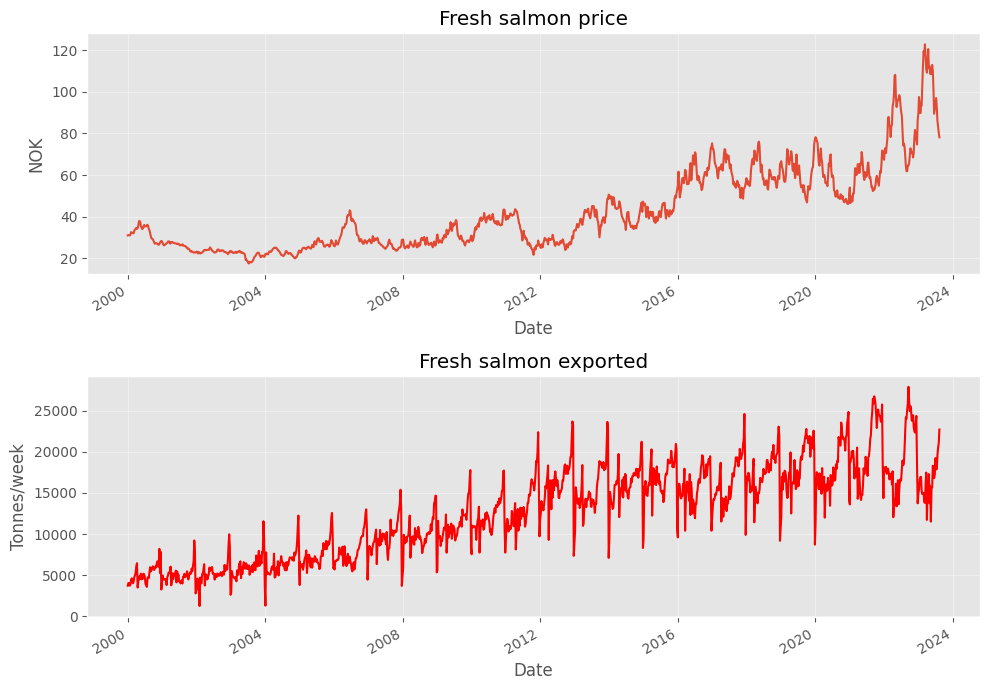

In [2]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

data = import_salmon_data(data_URL)

# Change index to datetime format
date_series = pd.to_datetime(data['uke'].str[:4] + data['uke'].str[-2:] + '1', format='%Y%W%w')
data.set_index(date_series, inplace=True)
data.drop(['uke'], axis=1, inplace=True)

display(data)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 7))

data['Kilopris (kr)'].plot(ax=ax1, ylabel='NOK')
data['Vekt (tonn)'].plot(ax=ax2, color='red', ylabel='Tonnes/week')
ax1.set_title('Fresh salmon price')
ax2.set_title('Fresh salmon exported')
ax1.grid(alpha=0.4); ax2.grid(alpha=0.4)
ax1.set_xlabel('Date'); ax2.set_xlabel('Date')
fig.tight_layout()


## Feature extraction

,Kilopris (kr),Vekt (tonn),Year,Week,Month,Day of year
uke,,,,,,
2000-01-03,30.98,3728,2000,1,1,3
2000-01-10,31.12,4054,2000,2,1,10
2000-01-17,31.03,4043,2000,3,1,17
2000-01-24,30.95,3730,2000,4,1,24
2000-01-31,31.30,3831,2000,5,1,31
...,...,...,...,...,...,...
2023-07-17,92.67,17898,2023,29,7,198
2023-07-24,86.14,19604,2023,30,7,205
2023-07-31,83.28,20469,2023,31,7,212


<Axes: xlabel='Week', ylabel='Vekt (tonn)'>

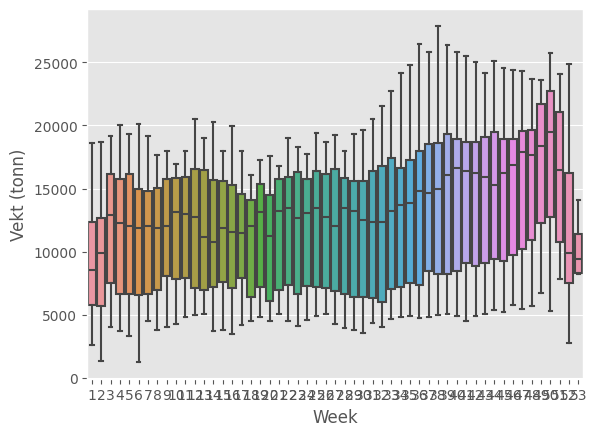

In [3]:
# Add lag faetures
def add_lags(df):
    df['Year'] = df.index.year
    df['Week'] = df.index.isocalendar().week.astype(int)
    df['Month'] = df.index.month
    df['Day of year'] = df.index.dayofyear

add_lags(data)

display(data)

sns.boxplot(data=data, x='Week', y='Vekt (tonn)')

## Model training

In [4]:
train, test = train_test_split(data, test_size=0.30, shuffle=True)

features = ['Year', 'Week', 'Month', 'Day of year']
targets = ['Vekt (tonn)', 'Kilopris (kr)']

x_train = train[features]
y_train = train[targets]

x_test = test[features]
y_test = test[targets]

reg_model = xgb.XGBRegressor(n_estimators=10000, early_stopping_rounds=1000)

reg_model.fit(
    x_train, y_train, 
    eval_set=[(x_train, y_train), (x_test, y_test)], 
    verbose=True
)

[0]	validation_0-rmse:6864.38075	validation_1-rmse:7018.22762
[1]	validation_0-rmse:4896.01316	validation_1-rmse:5015.32260
[2]	validation_0-rmse:3519.35060	validation_1-rmse:3617.93685


[3]	validation_0-rmse:2565.29326	validation_1-rmse:2678.74228
[4]	validation_0-rmse:1905.30491	validation_1-rmse:2050.28260
[5]	validation_0-rmse:1455.93025	validation_1-rmse:1622.06112
[6]	validation_0-rmse:1146.15871	validation_1-rmse:1360.76559
[7]	validation_0-rmse:936.31974	validation_1-rmse:1216.17078
[8]	validation_0-rmse:789.83499	validation_1-rmse:1126.58063
[9]	validation_0-rmse:691.66217	validation_1-rmse:1092.16377
[10]	validation_0-rmse:627.54341	validation_1-rmse:1070.23165
[11]	validation_0-rmse:584.50562	validation_1-rmse:1058.76860
[12]	validation_0-rmse:558.29888	validation_1-rmse:1051.14014
[13]	validation_0-rmse:537.66097	validation_1-rmse:1046.21956
[14]	validation_0-rmse:509.06330	validation_1-rmse:1034.21011
[15]	validation_0-rmse:498.66090	validation_1-rmse:1029.83514
[16]	validation_0-rmse:475.97239	validation_1-rmse:1028.26580
[17]	validation_0-rmse:468.18894	validation_1-rmse:1026.55905
[18]	validation_0-rmse:462.41063	validation_1-rmse:1022.99683
[19]	valida

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=1000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Model prediction

,Importance
Year,0.646389
Week,0.206879
Month,0.110580
Day of year,0.036152


,Date,Year,Week,Month,Day of year
Date,,,,,
2023-08-14,2023-08-14,2023,33,8,226
2023-08-15,2023-08-15,2023,33,8,227
2023-08-16,2023-08-16,2023,33,8,228
2023-08-17,2023-08-17,2023,33,8,229
2023-08-18,2023-08-18,2023,33,8,230
...,...,...,...,...,...
2025-12-20,2025-12-20,2025,51,12,354
2025-12-21,2025-12-21,2025,51,12,355
2025-12-22,2025-12-22,2025,52,12,356


Week 43:


,2023-10-23
Vekt (tonn),24321.085938
Kilopris (kr),79.664452


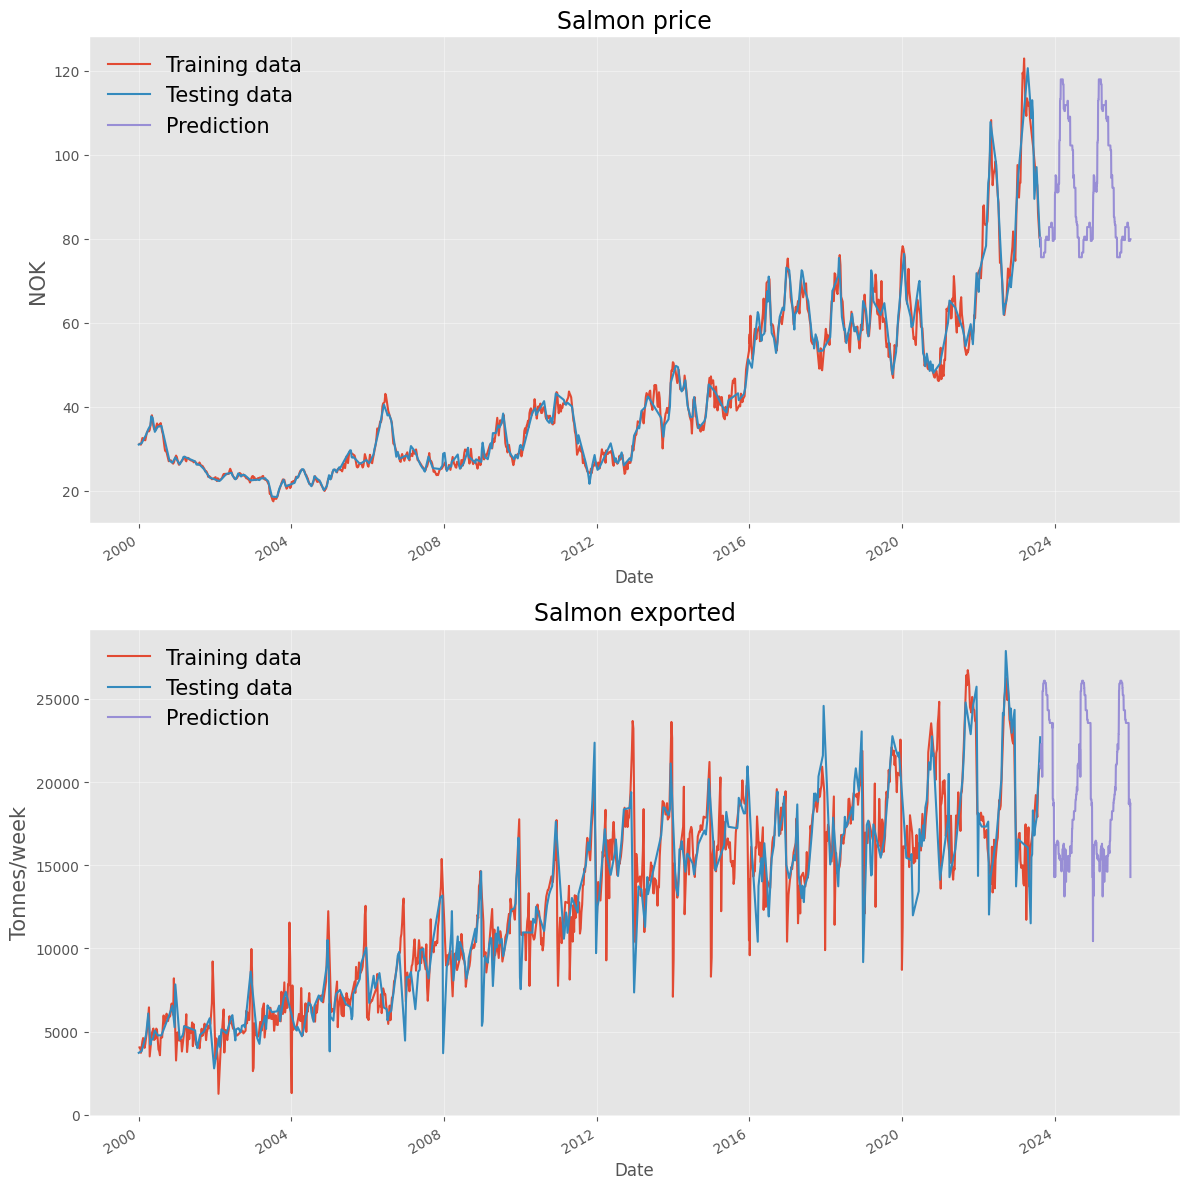

In [5]:
fi = pd.DataFrame(data=reg_model.feature_importances_, index=reg_model.feature_names_in_, columns=['Importance'])
display(fi)

future_dates = pd.DataFrame(
    pd.date_range(
        start=x_test.sort_values(by='uke').index[-1], 
        end='2025-12-24'
    ), columns=['Date']
)

future_dates.set_index(future_dates['Date'], inplace=True)
add_lags(future_dates)

display(future_dates)

future_dates.drop('Date', axis=1, inplace=True)

predictions = pd.DataFrame(reg_model.predict(future_dates), columns=targets, index=future_dates.index)

fig, axs = plt.subplots(2, figsize=(12, 12))

data_types = ['Training data', 'Testing data', 'Prediction']
label = ['NOK', 'Tonnes/week']
title = ['Salmon price', 'Salmon exported']

for i, target in enumerate(['Kilopris (kr)', 'Vekt (tonn)']):
    for j, data in enumerate([y_train, y_test, predictions]):
        data[target].plot(ax=axs[i], label=data_types[j])
        axs[i].legend(fontsize=15, frameon=False)
        axs[i].grid(alpha=0.4)
        axs[i].set_ylabel(label[i], fontsize=15)
        axs[i].set_title(title[i], fontsize=17)

fig.tight_layout()

# Week 43:
print('Week 43:')
display(pd.DataFrame(predictions.loc['2023-10-23']))